# 05 — Time Series Forecasting with ARIMA (PM2.5)
Mục tiêu:
- Làm sạch + chuẩn hoá chuỗi theo tần suất giờ (hourly) và xử lý missing.
- Kiểm tra **trend / seasonality / stationarity** (ADF, KPSS), ACF/PACF.
- Chọn tham số **(p,d,q)** bằng grid nhỏ (AIC/BIC) và dự báo bằng **ARIMA**.

> Lưu ý: Notebook này **chỉ dùng ARIMA** (statsmodels). 


In [1]:
from pathlib import Path
USE_UCIMLREPO = False
RAW_ZIP_PATH = 'data/raw/PRSA2017_Data_20130301-20170228.zip'
PROJECT_ROOT = Path().resolve()   # hoặc Path.cwd().resolve()
RAW_ZIP_PATH = str((PROJECT_ROOT / RAW_ZIP_PATH).resolve())
STATION = 'Aotizhongxin'
VALUE_COL = 'PM2.5'
CUTOFF = '2017-01-01'

P_MAX = 3
Q_MAX = 3
D_MAX = 2
IC = 'aic'   # 'aic' or 'bic'

ARTIFACTS_PREFIX = 'arima_pm25'


In [2]:
# Parameters
RAW_ZIP_PATH = "data/raw/PRSA2017_Data_20130301-20170228.zip"
STATION = "Aotizhongxin"
VALUE_COL = "PM2.5"
CUTOFF = "2017-01-01"
P_MAX = 3
Q_MAX = 3
D_MAX = 2
IC = "aic"
ARTIFACTS_PREFIX = "arima_pm25"


In [3]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from src.classification_library import (
    load_beijing_air_quality,
    clean_air_quality_df,
)
from src.timeseries_library import (
    StationSeriesConfig,
    make_hourly_station_series,
    describe_time_series,
    train_test_split_series,
    grid_search_arima_order,
    fit_arima_and_forecast,
)

# NOTE:
# - PROJECT_ROOT và RAW_ZIP_PATH được khai báo ở cell PARAMETERS (papermill chạy cell này trước).
# - Không override PROJECT_ROOT bằng Path('..') vì sẽ lệch khi chạy từ terminal / papermill.
try:
    PROJECT_ROOT
except NameError:
    from pathlib import Path
    PROJECT_ROOT = Path().resolve()

try:
    RAW_ZIP_PATH
except NameError:
    RAW_ZIP_PATH = str((PROJECT_ROOT / "data/raw/PRSA2017_Data_20130301-20170228.zip").resolve())

print("PROJECT_ROOT =", PROJECT_ROOT)
print("RAW_ZIP_PATH =", RAW_ZIP_PATH)


PROJECT_ROOT = D:\KHMT_16-01\Data Mining\air_quality_timeseries
RAW_ZIP_PATH = data/raw/PRSA2017_Data_20130301-20170228.zip


## 1) Load + clean + build 1 chuỗi theo station
Chúng ta dự báo **một** chuỗi (một trạm) để ARIMA đúng nghĩa univariate.

In [4]:
df = load_beijing_air_quality(use_ucimlrepo=False, raw_zip_path=str((PROJECT_ROOT / RAW_ZIP_PATH).resolve()))
df = clean_air_quality_df(df)
cfg = StationSeriesConfig(station=STATION, value_col=VALUE_COL, freq='H', fill_method='interpolate_time')
s = make_hourly_station_series(df, cfg)
print('series length:', len(s))
print('start/end:', s.index.min(), s.index.max())


series length: 35064
start/end: 2013-03-01 00:00:00 2017-02-28 23:00:00


D:\KHMT_16-01\Data Mining\air_quality_timeseries\src\timeseries_library.py:55: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  s = s.resample(cfg.freq).mean()


## 2) EDA + Diagnostics (trend, seasonality, stationarity)
Các tín hiệu cần quan sát để ra quyết định:
- Missing gaps (dữ liệu cảm biến hay thiếu)
- Seasonality theo **24h** và **7 ngày** (weekly)
- Stationarity: nếu không dừng -> cần differencing (d)


{
  "n": 35064,
  "missing_ratio": 0.0,
  "min": 3.0,
  "max": 898.0,
  "mean": 82.54062286105408,
  "std": 81.95640129983182,
  "adf_pvalue": 0.0,
  "kpss_pvalue": 0.1,
  "autocorr_lag_24": 0.40157518039673307,
  "autocorr_lag_168": 0.016796754924567895
}


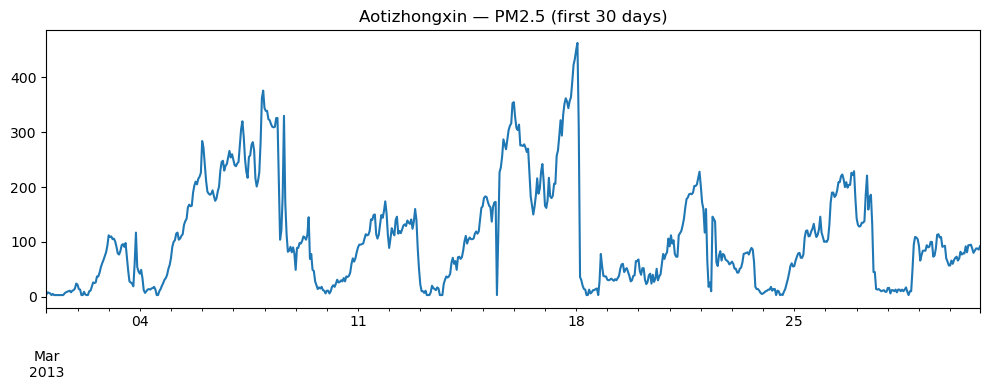

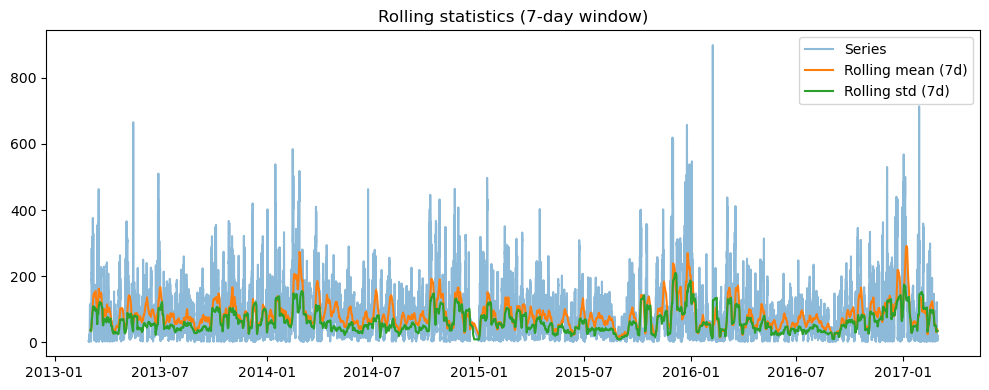

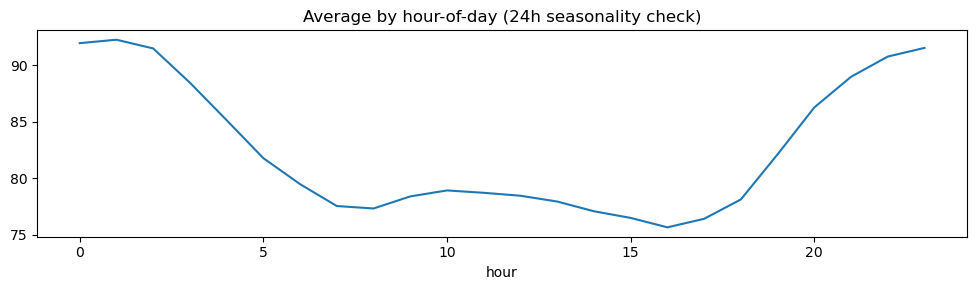

In [5]:
diag = describe_time_series(s)
print(json.dumps(diag, ensure_ascii=False, indent=2))

# Plot raw series (zoom a bit)
plt.figure(figsize=(10,4))
s.iloc[:24*30].plot()  # first 30 days
plt.title(f'{STATION} — {VALUE_COL} (first 30 days)')
plt.tight_layout()
plt.show()

# Rolling mean/std for intuition about stationarity
roll_mean = s.rolling(24*7, min_periods=24*3).mean()  # 7-day window
roll_std  = s.rolling(24*7, min_periods=24*3).std()
plt.figure(figsize=(10,4))
plt.plot(s.index, s.values, label='Series', alpha=0.5)
plt.plot(roll_mean.index, roll_mean.values, label='Rolling mean (7d)')
plt.plot(roll_std.index, roll_std.values, label='Rolling std (7d)')
plt.title('Rolling statistics (7-day window)')
plt.legend()
plt.tight_layout()
plt.show()

# Seasonality check: average by hour-of-day
tmp = pd.DataFrame({'y': s.values}, index=s.index)
hod = tmp.groupby(tmp.index.hour)['y'].mean()
plt.figure(figsize=(10,3))
plt.plot(hod.index, hod.values)
plt.title('Average by hour-of-day (24h seasonality check)')
plt.xlabel('hour')
plt.tight_layout()
plt.show()


## 3) Split theo thời gian + ACF/PACF (gợi ý p, q)
ACF/PACF giúp nhìn cấu trúc tương quan theo lag.
Trong thực tế ta vẫn cần kiểm chứng bằng AIC/BIC.

train: 2013-03-01 00:00:00 -> 2016-12-31 23:00:00 | n= 33648
test : 2017-01-01 00:00:00 -> 2017-02-28 23:00:00 | n= 1416


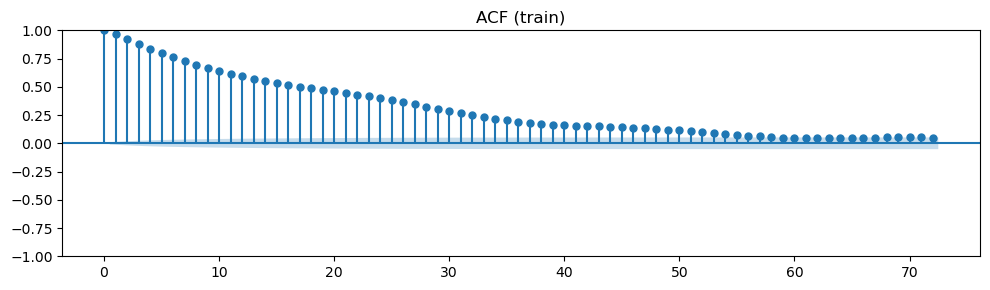

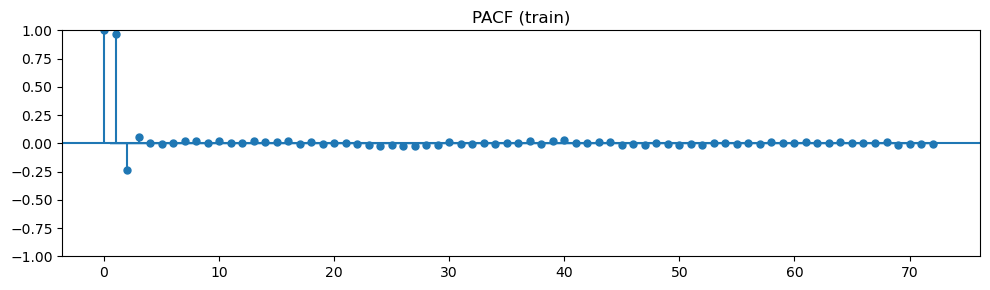

In [6]:
train, test = train_test_split_series(s, cutoff=CUTOFF)
print('train:', train.index.min(), '->', train.index.max(), '| n=', len(train))
print('test :', test.index.min(), '->', test.index.max(), '| n=', len(test))

x = train.dropna()
plt.figure(figsize=(10,3))
plot_acf(x, lags=72, ax=plt.gca())  # 3 days
plt.title('ACF (train)')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,3))
plot_pacf(x, lags=72, ax=plt.gca(), method='ywm')
plt.title('PACF (train)')
plt.tight_layout()
plt.show()


## 4) Grid search ARIMA(p,d,q) theo AIC/BIC và dự báo
Giữ grid nhỏ để chạy nhanh trong lab.

Best order: (1, 0, 3) | best aic = 294792.70634829206


,datetime,y_true,y_pred,lower,upper
0,2017-01-01 00:00:00,485.0,460.796484,422.895015,498.697953
1,2017-01-01 01:00:00,477.0,442.790204,383.069985,502.510423
2,2017-01-01 02:00:00,454.0,425.685614,351.185256,500.185972
3,2017-01-01 03:00:00,418.0,409.842475,324.425762,495.259189
4,2017-01-01 04:00:00,438.0,394.729760,300.472291,488.987228


{'rmse': 104.10353113893723, 'mae': 77.69129505192556}


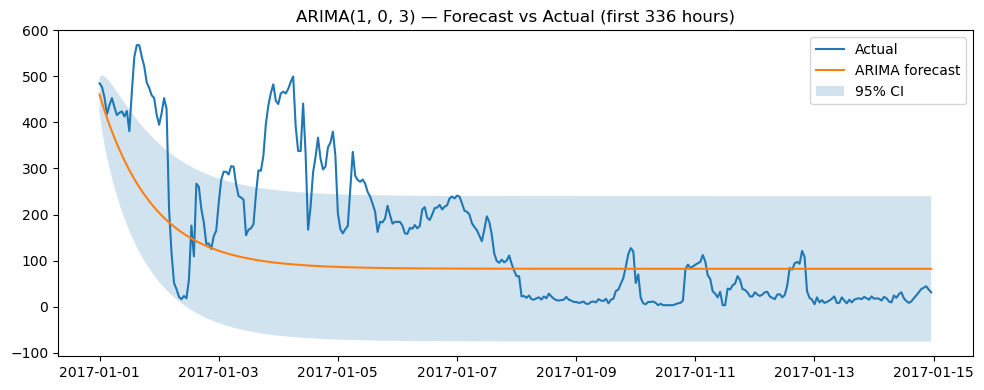

Saved: D:\KHMT_16-01\Data Mining\air_quality_timeseries\data\processed\arima_pm25_summary.json


In [7]:
gs = grid_search_arima_order(train, p_max=P_MAX, q_max=Q_MAX, d_max=D_MAX, d=None, ic=IC)
best_order = gs['best_order']
print('Best order:', best_order, '| best', IC, '=', gs['best_score'])

out = fit_arima_and_forecast(train, steps=len(test), order=best_order)
yhat = out['forecast']
ci = out['conf_int']

# Align with test index (same length)
pred_df = pd.DataFrame({
    'datetime': test.index[:len(yhat)],
    'y_true': test.values[:len(yhat)],
    'y_pred': yhat.values,
    'lower': ci.iloc[:,0].values,
    'upper': ci.iloc[:,1].values,
})
display(pred_df.head())

# Error metrics
mask = np.isfinite(pred_df['y_true']) & np.isfinite(pred_df['y_pred'])
rmse = float(np.sqrt(np.mean((pred_df.loc[mask,'y_true'] - pred_df.loc[mask,'y_pred'])**2)))
mae  = float(np.mean(np.abs(pred_df.loc[mask,'y_true'] - pred_df.loc[mask,'y_pred'])))
print({'rmse': rmse, 'mae': mae})

# Plot forecast (sample window)
plot_n = min(24*14, len(pred_df))  # first 14 days of test
p = pred_df.iloc[:plot_n].copy()
plt.figure(figsize=(10,4))
plt.plot(p['datetime'], p['y_true'], label='Actual')
plt.plot(p['datetime'], p['y_pred'], label='ARIMA forecast')
plt.fill_between(p['datetime'], p['lower'], p['upper'], alpha=0.2, label='95% CI')
plt.title(f'ARIMA{best_order} — Forecast vs Actual (first {plot_n} hours)')
plt.legend()
plt.tight_layout()
plt.show()

# Save artifacts
out_dir = (PROJECT_ROOT / 'data/processed')
out_dir.mkdir(parents=True, exist_ok=True)
pred_df.to_csv(out_dir / f'{ARTIFACTS_PREFIX}_predictions.csv', index=False)
out['result'].save(out_dir / f'{ARTIFACTS_PREFIX}_model.pkl')
summary = {
    'station': STATION,
    'value_col': VALUE_COL,
    'cutoff': CUTOFF,
    'best_order': best_order,
    'ic': IC,
    'best_score': gs['best_score'],
    'rmse': rmse,
    'mae': mae,
    'diagnostics': diag,
}
with open(out_dir / f'{ARTIFACTS_PREFIX}_summary.json', 'w', encoding='utf-8') as f:
    json.dump(summary, f, ensure_ascii=False, indent=2)
print('Saved:', out_dir / f'{ARTIFACTS_PREFIX}_summary.json')
